In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.decomposition import PCA
from wordcloud import WordCloud, STOPWORDS
import operator
import itertools
import matplotlib as mpl
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_train = pd.read_csv('../data/[UCI] AAAI-14 Accepted Papers - Papers.csv')
data_train = data_train[['title', 'groups', 'keywords', 'topics']]
print(len(data_train))
data_train.head()

398


,title,groups,keywords,topics
0,Kernelized Bayesian Transfer Learning,Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...
1,"""Source Free"" Transfer Learning for Text Class...",AI and the Web (AIW)\nNovel Machine Learning A...,Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...
2,A Generalization of Probabilistic Serial to Ra...,Game Theory and Economic Paradigms (GTEP),social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting
3,Lifetime Lexical Variation in Social Media,NLP and Text Mining (NLPTM),Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...
4,Hybrid Singular Value Thresholding for Tensor ...,Knowledge Representation and Reasoning (KRR)\n...,tensor completion\nlow-rank recovery\nhybrid s...,KRR: Knowledge Representation (General/Other)\...


将数据框架行作为组的函数展开

In [3]:
# 将groups列的内容用\n进行切分，按照每一行只有一个关键词排列
s = data_train['groups'].str.split('\n').apply(pd.Series, 1).stack()
# 去除MultiIndex就需要使用droplevel,将同一个样本的关键词用同一个标号表示
s.index = s.index.droplevel(-1)
s.name = 'groups'
del data_train['groups']
# 将构造好的作者选定的高级关键词列加入到数据集中
data_train = data_train.join(s).reset_index()

In [4]:
data_train['flags'] = pd.Series(np.ones(len(data_train)), index=data_train.index)
data_train.head()

,index,title,keywords,topics,groups,flags
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0


建立数据透视表，将训练数据转换为带标题的数据透视表作为索引，每个组由单独的列表示。

In [5]:
def matrix_from_df(data_train):
    # 建立透视表，论文题目作为dataframe的索引，对groups列进行聚合(类似于onehot编码)，利用flags计算groups中的每一个关键词出现了多少次
    matrix = data_train.pivot_table(index=['title'], columns=['groups'], values='flags')
    matrix = matrix.fillna(0).reset_index()
    # 取第一列到最后一列的数字
    x_cols = matrix.columns[1:]
    return matrix, x_cols
matrix, x_cols = matrix_from_df(data_train)
matrix.head()

groups,title,AI and the Web (AIW),Applications (APP),Cognitive Modeling (CM),Cognitive Systems (CS),Computational Sustainability and AI (CSAI),Game Playing and Interactive Entertainment (GPIE),Game Theory and Economic Paradigms (GTEP),Heuristic Search and Optimization (HSO),Human-Computation and Crowd Sourcing (HCC),...,Multiagent Systems (MAS),NLP and Knowledge Representation (NLPKR),NLP and Machine Learning (NLPML),NLP and Text Mining (NLPTM),Novel Machine Learning Algorithms (NMLA),Planning and Scheduling (PS),Reasoning under Uncertainty (RU),Robotics (ROB),Search and Constraint Satisfaction (SCS),Vision (VIS)
0,"""Source Free"" Transfer Learning for Text Class...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,A Characterization of the Single-Peaked Single...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"A Computational Method for (MSS,CoMSS) Partiti...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,A Control Dichotomy for Pure Scoring Rules,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A Convex Formulation for Semi-supervised Multi...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


在数据矩阵上应用肘法则和解释方差

Text(0.5,1,'Elbow for KMeans clustering')

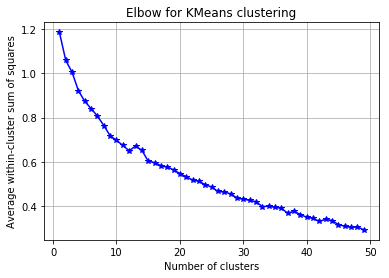

In [6]:
X = matrix[x_cols]
K = range(1, 50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
# 该函数用于计算两个输入集合的距离，通过metric参数指定计算距离的不同方式得到不同的距离度量值,euclidean：欧式距离
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
# 计算每种聚类方法中，样本到聚类中心最小的值
dist = [np.min(D, axis=1) for D in D_k]
# 计算簇内距离平方和的平均数
avgWithnSS = [sum(d)/X.shape[0] for d in dist]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithnSS, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
plt.title('Elbow for KMeans clustering')

解释方差在数据矩阵中的应用

Text(0.5,1,'Elbow for KMeans clustering')

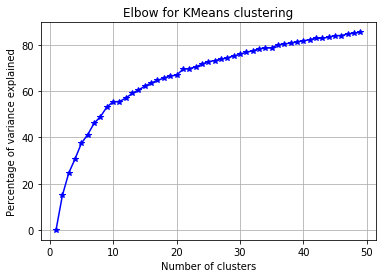

In [7]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
K = range(1, 50)
KM = [KMeans(n_clusters=k).fit(X) for k in K]
centroids = [k.cluster_centers_ for k in KM]
D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
dist = [np.min(D, axis=1) for D in D_k]
# 计算距离的平方和
wcss = [sum(d**2) for d in dist]
# pdist计算数组X样本之间的欧式距离
tss = sum(pdist(X)**2)/X.shape[0]
# 从总平方和中减去聚类内平方和
bss = tss - wcss
kIdx = 10-1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, bss/tss*100, 'b*-')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Percentage of variance explained')
plt.title('Elbow for KMeans clustering')

从数据矩阵中绘制轮廓系数评分图

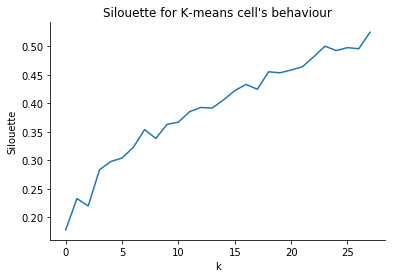

In [8]:
s = []
for n_clusters in range(2, 30):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    s.append(silhouette_score(X, labels, metric='euclidean'))
plt.plot(s)
plt.ylabel('Silouette')
plt.xlabel('k')
plt.title("Silouette for K-means cell's behaviour")
sns.despine()

In [9]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
cluster = KMeans(n_clusters=9, random_state=4)
matrix['cluster'] = cluster.fit_predict(X)
matrix.cluster.value_counts()

0    74
6    71
1    63
2    47
3    42
5    31
8    28
4    24
7    16
Name: cluster, dtype: int64

In [10]:
pca = PCA(n_components=2)
matrix['x'] = pca.fit_transform(matrix[x_cols])[:, 0]
matrix['y'] = pca.fit_transform(matrix[x_cols])[:, 1]
matrix = matrix.reset_index()
customer_clusters = matrix[['title', 'cluster', 'x', 'y']]
customer_clusters.head()

groups,title,cluster,x,y
0,"""Source Free"" Transfer Learning for Text Class...",3,0.615810,-0.060295
1,A Characterization of the Single-Peaked Single...,4,-0.756838,0.971322
2,"A Computational Method for (MSS,CoMSS) Partiti...",0,-0.287956,-0.216148
3,A Control Dichotomy for Pure Scoring Rules,5,-0.521295,0.570206
4,A Convex Formulation for Semi-supervised Multi...,1,0.198578,-0.129668


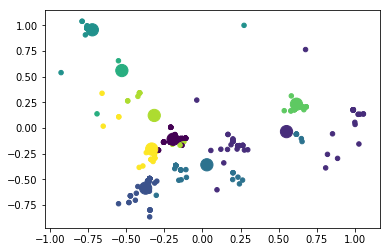

In [11]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
# c控制颜色
plt.scatter(customer_clusters['x'], customer_clusters['y'], s=20, c=customer_clusters['cluster'])
plt.scatter(cluster_centers['x'], cluster_centers['y'], s=150, c=cluster_centers['cluster'])

In [12]:
# 标题行没有名称，具体见https://blog.csdn.net/xxzhangx/article/details/76609925
customer_clusters.columns.name = None
# 以title为主键拼接data_train和customer_clusters
df = data_train.merge(customer_clusters, on='title')
df.head()

,index,title,keywords,topics,groups,flags,cluster,x,y
0,0,Kernelized Bayesian Transfer Learning,cross-domain learning\ndomain adaptation\nkern...,APP: Biomedical / Bioinformatics\nNMLA: Bayesi...,Novel Machine Learning Algorithms (NMLA),1.0,6,0.613870,0.245408
1,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,AI and the Web (AIW),1.0,3,0.615810,-0.060295
2,1,"""Source Free"" Transfer Learning for Text Class...",Transfer Learning\nAuxiliary Data Retrieval\nT...,AIW: Knowledge acquisition from the web\nAIW: ...,Novel Machine Learning Algorithms (NMLA),1.0,3,0.615810,-0.060295
3,2,A Generalization of Probabilistic Serial to Ra...,social choice theory\nvoting\nfair division\ns...,GTEP: Game Theory\nGTEP: Social Choice / Voting,Game Theory and Economic Paradigms (GTEP),1.0,5,-0.521295,0.570206
4,3,Lifetime Lexical Variation in Social Media,Generative model\nSocial Networks\nAge Prediction,AIW: Web personalization and user modeling\nNL...,NLP and Text Mining (NLPTM),1.0,0,-0.183192,-0.090091


为每个簇创建绘制词云的函数

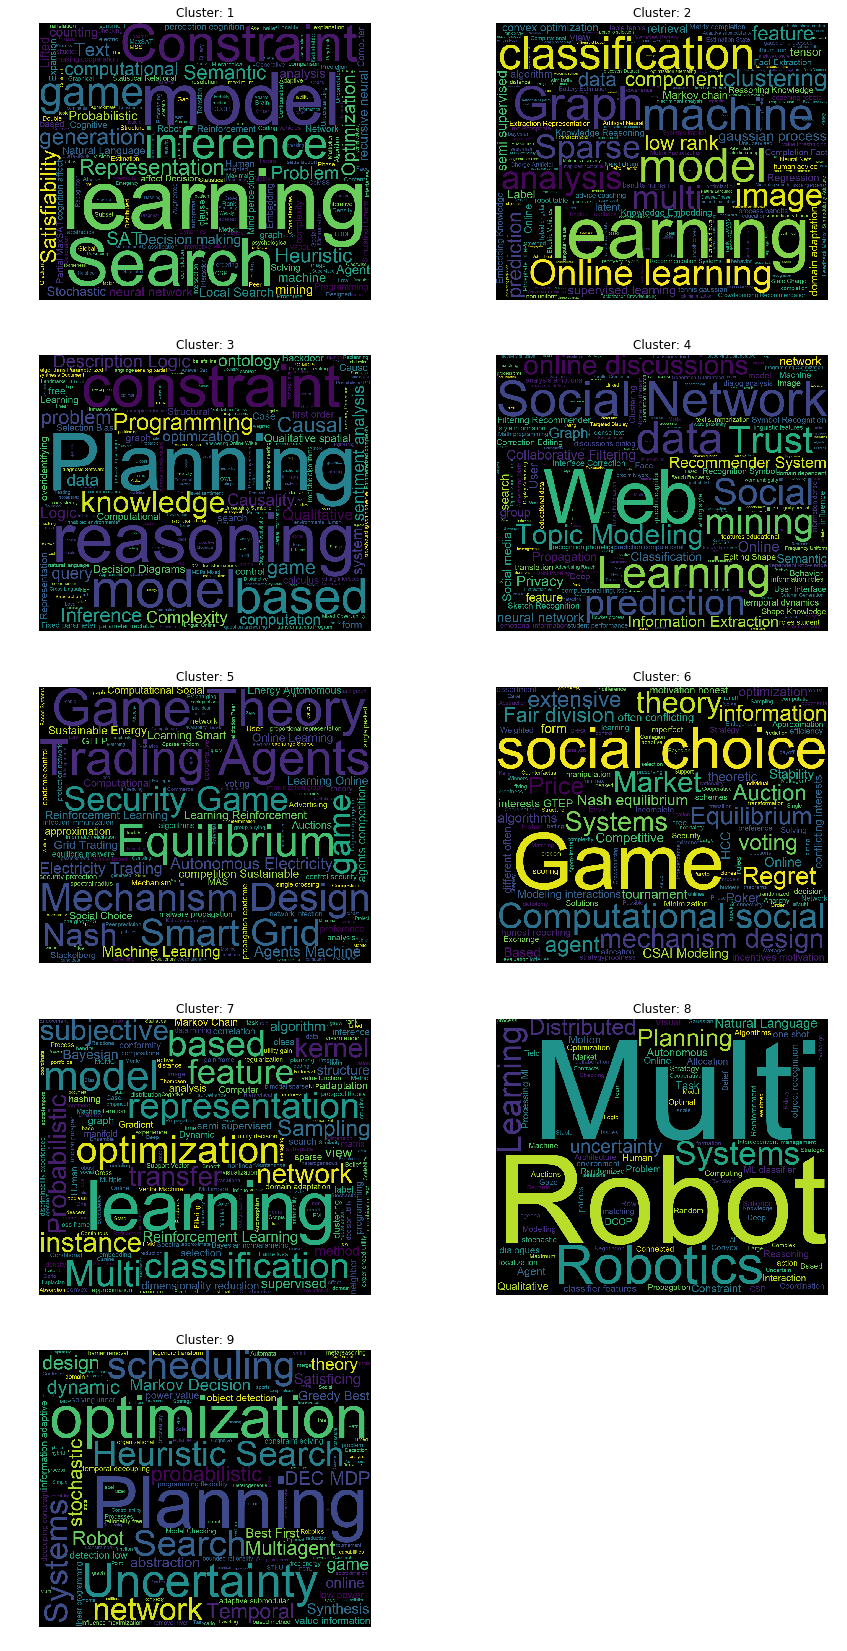

In [13]:
def wordcloud_object(word_string):
    FONT_ROOT = './fonts/'
    wordcloud = WordCloud(font_path=FONT_ROOT+'arial.ttf', stopwords=STOPWORDS, background_color='black', width=1200, height=1000).generate(' '.join(word_string))
    return wordcloud
# pivot参数是一个特征，通过它可以得到词袋，进而制作词云
def plot_wordcloud(df, clusters, pivot):
    fig = plt.figure(figsize=(15, 29.5))
    for cluster in range(clusters):
        List_ = []
        for x in df[df['cluster']==cluster][pivot]:
            try:
                List_.extend(x.split('\n'))
            except:
                pass
        if List_:
            ax = fig.add_subplot(5, 2, cluster+1)
            wordcloud = wordcloud_object(List_)
            plt.title('Cluster: %d' % (cluster+1))
            ax.imshow(wordcloud)
            ax.axis('off')
plot_wordcloud(df, cluster.n_clusters, 'keywords')

定义方法以查找给定簇的完整关键词和单构词

In [14]:
def perform_cluster_group_audit(df, clusters, term):
    for cluster in clusters:
        df_cluster = df[df['cluster'] == cluster]
        print('Cluster number: %d' % (cluster+1))
        keywords = list(df_cluster['keywords'])
        keywords = [keyword.split('\n') for keyword in keywords]
        keywords = [item for sublist in keywords for item in sublist]
        keywords = [keyword.lower() for keyword in keywords if term in keyword.lower()]
        keywords_freq = {x:keywords.count(x) for x in keywords}
        # reverse=True降序，key为函数指定取待排序元素的哪一项进行排序,operator模块提供的itemgetter函数用于获取对象的哪些维的数据
        print(sorted(keywords_freq.items(), key=operator.itemgetter(1), reverse=True))
        print('\n')
perform_cluster_group_audit(df, [0, 8], 'search')
perform_cluster_group_audit(df, [3, 5], 'social')

Cluster number: 1
[('local search', 2), ('stochastic local search', 2), ('and/or search', 2), ('similarity search', 1), ('approximate nearest neighbor search', 1), ('heuristic search', 1), ('real-time search', 1), ('agent-centered search', 1), ('hierarchical search', 1), ('parallel search', 1), ('bounded suboptimal search', 1), ('best-first search', 1), ('suboptimal heuristic search', 1)]


Cluster number: 9
[('heuristic search', 9), ('greedy best first search', 4), ('search', 3), ('monte carlo tree search', 2), ('incremental search', 1)]


Cluster number: 4
[('social networks', 6), ('social media', 5), ('social infectivity', 3), ('social network', 3), ('social spammer', 2), ('location based social network', 2), ('social network analysis', 2), ('heterogeneous social networks', 2), ('social influence', 2), ('social explanation', 1)]


Cluster number: 6
[('computational social choice', 11), ('social choice theory', 2), ('social decision schemes', 2), ('randomized social choice', 1)]




定义函数来绘制簇图

In [15]:
def plot_results(X, Y_, means, covariances, index, title):
    # cycle()会把传入的一个序列无限重复下去
    color_iter = itertools.cycle(['b', 'g', 'red', 'm', 'y', 'navy', 'c', 'cornflowerblue', 'gold', 'darkorange'])
    splot = plt.subplot(2, 1, 1+index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        # np.linalg.eigh()适用于对称矩阵,用于矩阵特征分解
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # Y_和i中只要有一个元素相等就可以返回true
        if not np.any(Y_ == i):
            continue
        temp = (Y_ == i)
        save_loc = []
        location = 0
        for i in temp:
            if i == True:
                save_loc.append(location)
            location += 1   
        plt.scatter(list(X.iloc[save_loc]['x']), list(X.iloc[save_loc]['y']), s=30, color=color)
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.+angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
    plt.xlim(0.0, 0.1)
    plt.ylim(-0.2, 1.2)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

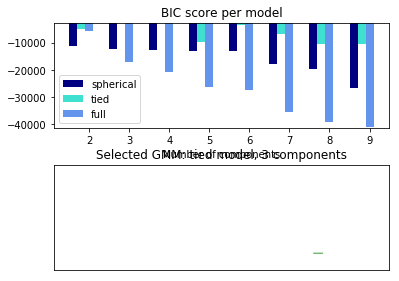

In [16]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
model_stats = []
n_components_range = range(2, 10)
# 高斯混合模型由以下变量来约束不同聚类估计的协方差：spherical:球形、tied:并列、full:完整的协方差
cv_types = ['spherical', 'tied', 'full']
for cv_type in cv_types:
    # 在每一种聚类簇个数的情况下
    for n_components in n_components_range:
        # 高斯混合模型聚类
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type, random_state=0)
        gmm.fit(X)
        # BIC为似然函数与参数及样本量的组合，选择该值最小的模型
        model_stats.append({'name': '%s_%d' % (cv_type, n_components), 'model': gmm, 'bic': gmm.bic(X)})
bic = np.array([m_type['bic'] for m_type in model_stats])
# argmax返回的是最大数的索引
best_gmm = model_stats[bic.argmax()]
# 保存模型的名称
clf = best_gmm['model']
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue'])
bars = []
spl = plt.subplot(2, 1, 1)
# 这里的i表示cv_types分为几类
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i-2)
    # 条形图
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i+1)*len(n_components_range)], width=.2, color=color))
# 设置x轴刻度的表现方式
plt.xticks(n_components_range)
plt.ylim([bic.min()*1.01-.01*bic.max(), bic.max()])
plt.title('BIC score per model')
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
labels = clf.predict(X)
plot_results(df, labels, gmm.means_, gmm.covariances_, 1, 'Gaussian Mixture-%s' % gmm.converged_)
plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: %s model, %s components' % (best_gmm['name'].split('_')[0], best_gmm['name'].split('_')[1]))
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

对高斯混合模型的聚类结果进行可视化分析

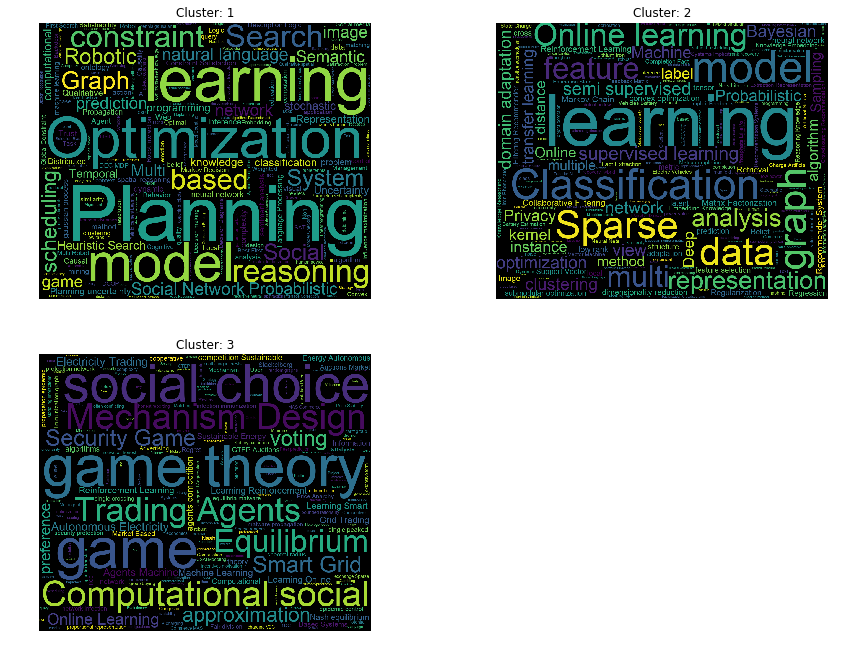

In [17]:
matrix['clusters'] = labels
matrix.clusters.value_counts()
customer_clusters.columns.name = None
temp = matrix[['title', 'clusters']]
customer_clusters = customer_clusters.merge(temp, on='title')
df = data_train.merge(customer_clusters, on='title')
df.drop('cluster',axis=1, inplace=True)
df.drop('x',axis=1, inplace=True)
df.drop('y',axis=1, inplace=True)
df.columns = ['index', 'title', 'keywords', 'topics', 'groups', 'flags', 'cluster']
plot_wordcloud(df, 3, 'keywords')

In [18]:
df.columns

Index(['index', 'title', 'keywords', 'topics', 'groups', 'flags', 'cluster'], dtype='object')

贝叶斯高斯混合模型

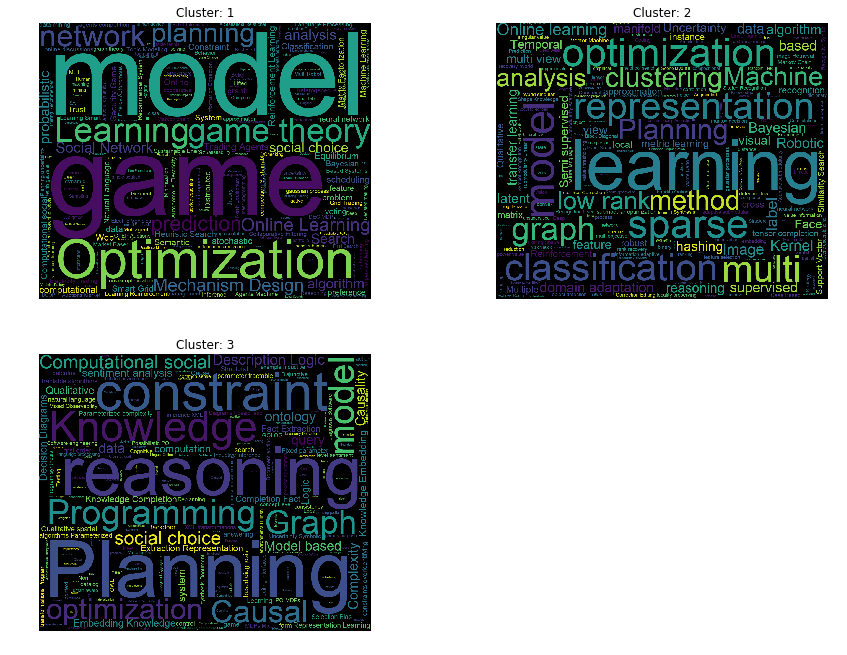

In [19]:
matrix, x_cols = matrix_from_df(data_train)
X = matrix[x_cols]
dpgmm = mixture.BayesianGaussianMixture(n_components=3, covariance_type='full', random_state=1).fit(X)
labels = dpgmm.predict(X)
matrix['clusters'] = labels
matrix.clusters.value_counts()
customer_clusters.columns.name = None
temp = matrix[['title', 'clusters']]
customer_clusters = customer_clusters.merge(temp, on='title')
df = data_train.merge(customer_clusters, on='title')
df.drop('cluster',axis=1, inplace=True)
df.drop('x',axis=1, inplace=True)
df.drop('y',axis=1, inplace=True)
df.drop('clusters_x',axis=1, inplace=True)
df.columns = ['index', 'title', 'keywords', 'topics', 'groups', 'flags', 'cluster']
plot_wordcloud(df, 3, 'keywords')